# 深層学習ノートブック-5 MLP(多層パーセプトロン)
MNISTデータセットについて、多層パーセプトロンをスクラッチで実装して予測値を算出する

実装方針：
* 隠れ層は1層のみ
* 隠れ層のニューロンの数: 30
    * MNISTでは最終的に１データ当たり10の予測値（確率）が欲しいので、  
    隠れ層のニューロンの数が30の場合、パラメタ$\bm{W}, \bm{b}$のshapeは下記である必要がある。
        * 入力層→隠れ層: 
            * $\bm{W}$: 30 x 特徴量数
            * $\bm{b}$: 1 x 30
        * 隠れ層→出力層: 
            * $\bm{W}$: クラス数(MNISTでは10) x 30
            * $\bm{b}$: 1 x 10
* 隠れ層の活性化関数にはReLUを使用
* モデルの関数を作成し，順伝播（入力層→出力層まで左から右に計算すること）で予測した結果を返す

# ●前処理・初期化

In [1]:
import torch
import torch.nn.functional as F  #pytorchの便利関数はFでimportすることが多い。
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# python debugerをインポート
import pdb

In [2]:
# 変数定義
learning_rate = 0.03
loss_log = []  #学習時の損失記録用のリスト

In [3]:
# データロード
dataset = datasets.load_digits()
feature_names = dataset['feature_names']
X = torch.tensor(dataset['data'], dtype=torch.float32)
target = torch.tensor(dataset['target'])

# shape確認
print(f'shape of X: {X.shape}')
print(X[1])
print('==========================')
print(f'shape of y_train: {target.shape}')
print(target)

shape of X: torch.Size([1797, 64])
tensor([ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,  9.,
         0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7., 15., 16.,
        16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,  0.,  0.,  0.,
         1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,
         0.,  0.,  0., 11., 16., 10.,  0.,  0.])
shape of y_train: torch.Size([1797])
tensor([0, 1, 2,  ..., 8, 9, 8])


In [4]:
# 目的変数のエンコーディング
y_true = F.one_hot(target, num_classes=10)
print(f'shape of y_true: {y_true.shape}')

shape of y_true: torch.Size([1797, 10])


In [5]:
# 学習データと検証データを8:2に分ける
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)

print(f'shape of train data: X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'shape of validation data: X_val:{X_val.shape}, y_val:{y_val.shape}')

shape of train data: X_train:torch.Size([1437, 64]), y_train:torch.Size([1437, 10])
shape of validation data: X_val:torch.Size([360, 64]), y_val:torch.Size([360, 10])


In [6]:
# 学習データ・検証データの標準化。検証データの標準化には学習データの平均、標準偏差を使用することに注意。  
# 今回のようなデータの場合、全体の平均・標準偏差で標準化するでOK
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

In [7]:
# 入力層→隠れ層の重みW、バイアス項bの初期化
W_1 = torch.randn(size=(30, 64) ,requires_grad=True) #出力×入力
b_1 = torch.randn(size=(1, 30), requires_grad=True) # 1 x 出力

# 隠れ層→出力層の重みW、バイアス項bの初期化
W_2 = torch.randn(size=(10, 30) ,requires_grad=True) #出力×入力
b_2 = torch.randn(size=(1, 10), requires_grad=True) # 1 x 出力

今回はrandではなくrandn(正規分布からの乱数)を用いている。  

In [185]:
# softmax関数の実装
def softmax_func(X):
    '''
    X: input tensor.行は各データ、列は各クラスを想定。
    '''
    # x_kが大きすぎると、e^xがinfになるのでmax(x_1, x_2,...,x_K)を各x_kから引く。
    # 各データ（各行）について最大値を求める必要があるので、dimにRank1(列方向で比較)を指定する。
    max_val = X.max(dim=1, keepdim=True).values
    # 各要素のe^xを計算（これが分子になる）
    e_x = (X - max_val).exp()

    # softmax関数の分母の計算
    # 各データについて合計したいので、dim=1を設定。また、分母が0になることを防ぐために分母の式に1e-10を足しておく
    denominator = e_x.sum(dim=1, keepdim=True) + 1e-10

    return e_x / denominator


In [47]:
# 多クラス分類に対応した交差エントロピー
def cross_entropy(y_true, y_pred):
    '''
    y_true: tensor。One-Hot Encoding済みの正解ラベル。
    y_pred: tensor。予測値。softmax関数の出力(0~100%)。
    '''
    # 損失を計算。最終的な損失はスカラーなので、dimを指定する必要はない。
    return - (y_true * torch.log(y_pred + 1e-10)).sum() / y_true.shape[0]


In [37]:
# ReLUの実装
def Relf(z):
    # torch.whereによって要素ごとに条件が真・偽のときで別の値を返せる
    # 下記では0より大きい要素はzの値そのままで、0以下は0.になる。
    return torch.where(z > 0 , z, 0.)

## MLPをスクラッチで実装

In [186]:
# ミニバッチのサイズ定義
batch_size = 32

# 全ミニバッチの数。ミニバッチサイズで割ったときの余りも考慮してプラス１
batch_num = len(y_train) // batch_size + 1

# 最後のミニバッチのデータ数
#batch_remainder_num = len(y_train) % batch_size

# 各epochごとの学習データ・検証データでの損失記録用
loss_per_epoch_train = []
loss_per_epoch_val = []

# 各epochごとの検証データでのAccuracy結果格納用
accuracy_log = {}


# for文で学習ループ作成
for epoch in range(1000):
    # epochごとの損失を蓄積する用の変数
    running_loss = 0
    running_loss_val = 0

    # バッチごとの処理対象データ開始・終了インデックスを初期化
    batch_start_idx = 0
    batch_end_idx = batch_size

    # シャッフル後のindex
    shuffled_indices = np.random.permutation(len(y_train))

    # ミニバッチ勾配降下法
    for i in range(batch_num):
        #print(f'batch{i}: start idx:{batch_start_idx}, end idx:{batch_end_idx}')
        #シャッフル後のindexからy,Xで同じ範囲を取り出しだしてミニバッチ作成
        batch_indices = shuffled_indices[batch_start_idx : batch_end_idx]
        y_train_batch = y_train[batch_indices, :]
        X_batch = X_train[batch_indices, :]
        #pdb.set_trace()

        # zの計算
        z = X_batch @ W.T + b # 1 x クラス数

        # softmaxで予測値算出
        y_pred = softmax_func(z)

        # 学習データに対するlossの計算・記録
        loss = cross_entropy(y_train_batch, y_pred)
        loss_log.append(loss.item())
        running_loss += loss.item()


        # Lの勾配計算。これをすることでw,bによるlossの偏微分係数が求められるようになる
        loss.backward()

        # パラメタ更新。更新するだけなので勾配の保持は不要。
        with torch.no_grad():
            W -= learning_rate * W.grad
            b -= learning_rate * b.grad

        # 勾配初期化
        W.grad.zero_()
        b.grad.zero_()

        # batch開始・終了インデックスを更新。スライシングの仕様上、endがlen(y_train)を超えても問題ない。
        batch_start_idx += batch_size
        batch_end_idx += batch_size


    # 検証データに対する予測、lossの計算・記録（1epochにつき1回算出）
    with torch.no_grad():
        z_val = X_val @ W.T + b
        y_pred_val = softmax_func(z_val)
        loss_val = cross_entropy(y_val, y_pred_val)

    # epochの最終的な損失を出力。各バッチの損失の累積を全バッチ数で割って平均を求める
    loss_per_epoch_train.append(running_loss / batch_num)
    loss_per_epoch_val.append(loss_val.item())

    # 検証データに対するaccuracyの計算
    accuracy_log[epoch] = ( (torch.argmax(y_pred_val, dim=1) == y_val.argmax(dim=1)).sum() / len(y_val) ).item()

In [187]:
accuracy_log

{0: 0.3861111104488373,
 1: 0.6305555701255798,
 2: 0.7194444537162781,
 3: 0.800000011920929,
 4: 0.8416666388511658,
 5: 0.8694444298744202,
 6: 0.8777777552604675,
 7: 0.8861111402511597,
 8: 0.8833333253860474,
 9: 0.9083333611488342,
 10: 0.9138888716697693,
 11: 0.9222221970558167,
 12: 0.9277777671813965,
 13: 0.9277777671813965,
 14: 0.9277777671813965,
 15: 0.9333333373069763,
 16: 0.9361110925674438,
 17: 0.9388889074325562,
 18: 0.9416666626930237,
 19: 0.9388889074325562,
 20: 0.9388889074325562,
 21: 0.9361110925674438,
 22: 0.9472222328186035,
 23: 0.9472222328186035,
 24: 0.9472222328186035,
 25: 0.9472222328186035,
 26: 0.9472222328186035,
 27: 0.949999988079071,
 28: 0.9472222328186035,
 29: 0.9472222328186035,
 30: 0.9472222328186035,
 31: 0.9472222328186035,
 32: 0.9472222328186035,
 33: 0.9472222328186035,
 34: 0.9472222328186035,
 35: 0.949999988079071,
 36: 0.9472222328186035,
 37: 0.949999988079071,
 38: 0.9472222328186035,
 39: 0.9472222328186035,
 40: 0.9472222

## ※補足　検証データに対する予測算出について  
上記では各epochごとに算出しているが、検証データが大きい場合は検証データもミニバッチごとに算出したりする。  

# ●学習曲線の描画
学習データと検証データでの損失の推移を確認してみる。

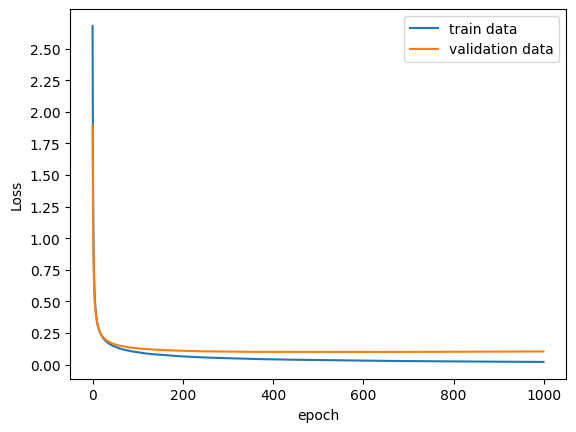

In [188]:
plt.plot(loss_per_epoch_train, label='train data')
plt.plot(loss_per_epoch_val, label='validation data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 2.5, 11))
plt.legend()

学習データと検証データで学習曲線は大きく乖離していないため、  
上手く学習が進んでいると思われる。  

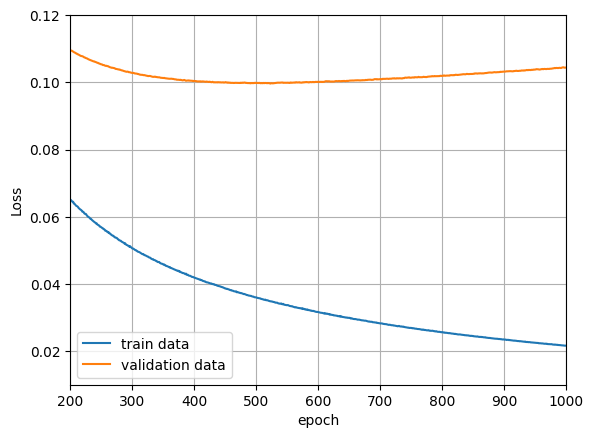

In [209]:
plt.plot(loss_per_epoch_train, label='train data')
plt.plot(loss_per_epoch_val, label='validation data')
plt.xlabel('epoch')
plt.xlim((200, 1000))
plt.ylabel('Loss')
plt.ylim((0.01, 0.12))
#plt.yticks(np.linspace(0.0, 0.25, 7))
plt.legend()
plt.grid()

Lossを拡大してみると、epoch=600以降で検証データに対するLossが増え始めており、  
過学習の兆候が見られる。なので、この場合はepoch=600程度で学習を打ち切るのが良さそう。  
このように学習曲線を描くことで反復回数といったハイパーパラメータの戦略が立てられる。   